In [1]:
import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
from scipy import stats
import statsmodels.api as sm

import lmoments3 as lm
from lmoments3 import distr

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

In [2]:
ds = xr.open_dataset('./data/ERA5-WRF_45km_monthly.nc')
ds

<xarray.Dataset>
Dimensions:            (time: 852, y: 104, x: 109)
Coordinates:
  * time               (time) datetime64[ns] 1950-09-01 ... 2021-08-01
    Lambert_Conformal  int32 ...
    lakemask           (y, x) float32 ...
    landmask           (y, x) float32 ...
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
  * x                  (x) float64 -6.285e+06 -6.24e+06 ... -1.47e+06 -1.425e+06
  * y                  (y) float64 -1.126e+06 -1.081e+06 ... 3.464e+06 3.509e+06
Data variables:
    T2                 (time, y, x) float32 ...

In [3]:
ds['T2'].data = (ds['T2'].data - 273.15) * (9/5) + 32
ds['T2'].attrs['units'] = 'F'

In [4]:
da = ds['T2']

In [30]:
stations = pd.read_csv('./data/weather_stations.csv')
stations.tail()

,STATE,STATION,CITY,FAA,LAT_Y,LON_X
27,CA,LANCASTER WILLIAM J FOX FIELD,LANCASTER,KWJF,34.74121,-118.21255
28,CA,ARCATA EUREKA AP,ARCATA,KACV,40.97844,-124.10479
29,CA,SACRAMENTO METROPOLITAN AP,SACRAMENTO,KSMF,38.70069,-121.59479
30,CA,STOCKTON AP,STOCKTON,KSCK,37.88997,-121.22637
31,CA,REDDING AP,REDDING,KRDD,40.51462,-122.29773


In [69]:
lons = stations.LON_X[0]
lats = stations.LAT_Y[0]

In [70]:
# pull projection values from netcdf file
projection = ccrs.LambertConformal(central_longitude=-70,
                             central_latitude=38,
                             standard_parallels=[30., 60.])

#function to transform points accordingly
transform = np.vectorize(lambda x, y: projection.transform_point(x, y, ccrs.PlateCarree()))

desired_x, desired_y = transform(lons, lats)

In [78]:
da_stations = da.sel(x=desired_x, y=desired_y, method='nearest')
print(da_stations)

<xarray.DataArray 'T2' (time: 852)>
array([68.29229 , 64.532715, 59.219284, 54.272583, 47.408764, 51.498642,
       53.98172 , 57.667137, 63.60492 , 67.48507 , 73.79754 , 71.87328 ,
       71.37494 , 61.291912, 55.185436, 44.826866, 44.12984 , 50.02664 ,
       47.859314, 58.25331 , 66.9769  , 63.231987, 74.74527 , 72.94253 ,
       72.47984 , 62.914867, 51.73507 , 47.241497, 50.911316, 50.461807,
       52.737957, 55.91619 , 58.195305, 65.98022 , 78.612625, 70.62084 ,
       71.25261 , 61.986084, 56.174866, 49.7238  , 46.519203, 55.755684,
       50.495155, 61.452644, 66.45851 , 69.142685, 78.46651 , 69.78478 ,
       69.93359 , 60.781433, 56.054512, 46.796   , 43.369476, 48.72306 ,
       53.792038, 54.55191 , 62.382854, 67.512695, 72.05725 , 76.648605,
       72.025055, 61.934227, 51.666847, 49.43882 , 48.571503, 44.92036 ,
       54.018578, 56.76181 , 62.875427, 70.62178 , 72.8208  , 70.2834  ,
       71.69975 , 58.18454 , 56.724403, 50.59733 , 43.966145, 52.149364,
       53.46085

In [80]:
ams = da_stations.groupby('time.year').max('time')

In [82]:
lmom_gev = distr.gev.lmom_fit(ams)
lmom_gev

OrderedDict([('c', 0.35492408681465815),
             ('loc', 75.27721455138726),
             ('scale', 2.290334288706858)])

In [83]:
fit_gev = stats.genextreme(**lmom_gev)
fit_gev

In [76]:
return_year=10
return_period = 1.0-(1./return_year)
return_value = fit_gev.ppf(return_period)
return_value

78.82696489095808

In [87]:
return_periods  = [2, 5, 10, 20, 30, 40, 50]

return_intervals = np.empty(len(return_periods))

for i in range(len(return_periods)):
    return_intervals[i] = 1.0-(1.0 / return_periods[i])
    
values = fit_gev.ppf(return_intervals)

pd.DataFrame({'return_periods': return_periods, 'values': values}, 
             columns=['return_periods', 'values'])

,return_periods,values
0,2,76.064345
1,5,77.940929
2,10,78.826965
3,20,79.481534
4,30,79.788894
5,40,79.979987
6,50,80.114720


In [84]:
ks = [('GEV', stats.kstest(ams, 'genextreme', 
             args=(lmom_gev['c'], lmom_gev['loc'], lmom_gev['scale'])))]

labels = ['distribution', 'KS (statistics, pvalue)']
pd.DataFrame(ks, columns=labels)

,distribution,"KS (statistics, pvalue)"
0,GEV,"(0.04706328334932973, 0.9950410481091314)"


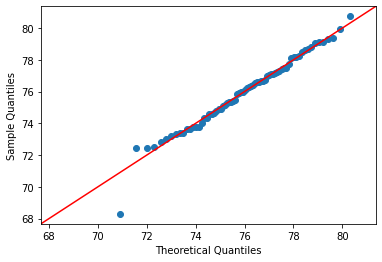

In [85]:
sm.qqplot(ams, stats.genextreme, distargs= (lmom_gev['c'],), loc=lmom_gev['loc'], scale=lmom_gev['scale'], line='45');